# Analyse d’images PSD
But : extraire et d’analyser les maxima locaux (pics) dans une image au format `.npy`

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from scipy.optimize import curve_fit
from matplotlib.patches import Circle

## Définition des paramètres de base
- **RELATIVE_FILENAME** : nom du fichier `.npy` à charger.  
- **PHYS_WIDTH**, **PHYS_HEIGHT** : dimensions physiques de l’image (en unités de longueur), utilisées pour convertir les positions de pixels en distances réelles.


In [118]:
RELATIVE_FILENAME = r"C:\Users\yanns\Documents\GitHub\MNP24_Saugy_Yann\SSP\AtomicScaleZ36FFT.npy"
PHYS_WIDTH = 201.4
PHYS_HEIGHT = 201.4

## Paramètres d’analyse
Ces variables contrôlent la détection des pics :
- `rmin`, `rmax` : intervalle de rayons pour restreindre la recherche autour du centre.  
- `threshold_rel`, `threshold_abs` : seuils relatif et absolu pour filtrer les maxima locaux.  
- `min_distance` : distance minimale entre deux pics détectés.  
- `window` : taille de la fenêtre considérée pour l’ajustement gaussien.


In [119]:
rmin = 25.0
threshold_rel = 0.2
threshold_abs = 0.0
min_distance = 5
window = 3

## Chargement et lissage de l’image
1. On charge les données brutes depuis le fichier `.npy`.  
2. On applique un filtre gaussien (`gaussian_filter`) pour atténuer le bruit haute fréquence avant détection des pics.


In [120]:
data = gaussian_filter(np.load(RELATIVE_FILENAME), sigma=0)
center = np.array(data.shape[::-1]) // 2
scale_x = PHYS_WIDTH / data.shape[1]
scale_y = PHYS_HEIGHT / data.shape[0]

## Détection des pics
Définition de la fonction `detect_peaks` qui :
- Localise les maxima locaux via `peak_local_max`.  
- Filtre ces maxima selon les conditions sur le rayon et les seuils.  
- Renvoie la liste des coordonnées candidates pour l’ajustement ultérieur.


In [121]:
# Détection des pics
def detect_peaks(data, center, r_min, threshold_rel, threshold_abs, min_distance):
    y_idx, x_idx = np.indices(data.shape)
    r = np.sqrt((x_idx - center[0])**2 + (y_idx - center[1])**2)
    masked = np.where(r >= r_min, data, 0)
    return peak_local_max(masked, min_distance=min_distance,
                          threshold_rel=threshold_rel, threshold_abs=threshold_abs)

## Localisation initiale des pics
- On calcule le centre approximatif de l’image (`center`).  
- On appelle `detect_peaks` pour obtenir les coordonnées des maxima locaux à analyser.


In [122]:
coords = detect_peaks(data, center, rmin, threshold_rel, threshold_abs, min_distance)
print(f"Pics détectés : {len(coords)}")

Pics détectés : 6


## Modèle gaussien pour l’ajustement
On définit une fonction gaussienne 2D (`gaussian`) :
$$
G(x,y) = A \exp\!\Bigl(-\tfrac{(x-x_0)^2}{2\sigma_x^2} - \tfrac{(y-y_0)^2}{2\sigma_y^2}\Bigr) + B
$$


In [123]:
# Fonction gaussienne pour fitting
def gaussian_2d(coords, amplitude, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coords
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    return (offset + amplitude * np.exp(-(a*(x - x0)**2 + 2*b*(x - x0)*(y - y0) + c*(y - y0)**2))).ravel()

## Ajustement gaussien d’un pic individuel
Pour chaque pic détecté :
1. On extrait une petite fenêtre centrée sur le pic.  
2. On lance `curve_fit` pour trouver les paramètres optimaux : position (`x0`,`y0`), écarts-types (`σx`,`σy`), amplitude `A`.  
3. On stocke les résultats et leurs incertitudes pour chaque pic.

In [124]:
# Ajustement d'un pic individuel
def fit_peak(data, coord, window_size):
    y0, x0 = coord
    slice_x = slice(max(int(x0 - window_size), 0), min(int(x0 + window_size), data.shape[1]))
    slice_y = slice(max(int(y0 - window_size), 0), min(int(y0 + window_size), data.shape[0]))
    sub = data[slice_y, slice_x]

    if sub.size == 0:
        return None

    y_idx, x_idx = np.indices(sub.shape)
    mask = np.sqrt((x_idx - sub.shape[1]/2)**2 + (y_idx - sub.shape[0]/2)**2) <= window_size

    x_flat, y_flat, z_flat = x_idx[mask].ravel(), y_idx[mask].ravel(), sub[mask].ravel()

    init_params = (np.ptp(z_flat), sub.shape[1]/2, sub.shape[0]/2, 2, 2, 0, np.min(z_flat))

    try:
        popt, pcov = curve_fit(gaussian_2d, (x_flat, y_flat), z_flat, p0=init_params)
        x_fit, y_fit = popt[1] + slice_x.start, popt[2] + slice_y.start
        err_x = np.sqrt(pcov[1, 1]) if np.isfinite(pcov[1, 1]) else np.nan
        err_y = np.sqrt(pcov[2, 2]) if np.isfinite(pcov[2, 2]) else np.nan
        return x_fit, y_fit, err_x, err_y
    except Exception as e:
        print(f"Fit échoué pour pic {coord}: {e}")
        return None

## Visualisation des pics ajustés
- Affichage de l’image lissée en fond.  
- Superposition des cercles sur chaque pic ajusté (rayon fonction de l’écart-type).  
- Permet de vérifier qualitativement la qualité de l’ajustement.


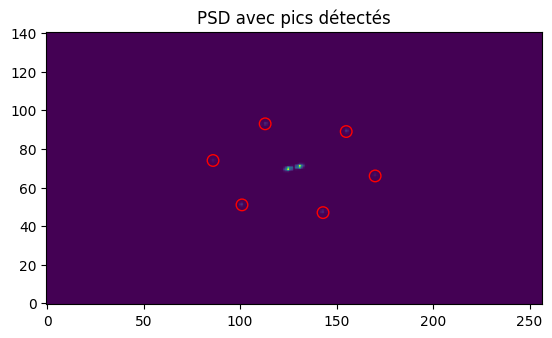

# dx_phys, dy_phys, err_x_phys, err_y_phys
-21.397, -27.122, nan, nan
21.397, 27.122, nan, nan
11.498, -32.366, nan, nan
-11.498, 32.366, nan, nan
32.861, -5.268, nan, nan
-32.861, 5.268, nan, nan


C:\Users\yanns\AppData\Local\Temp\ipykernel_3816\583004572.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gaussian_2d, (x_flat, y_flat), z_flat, p0=init_params)


In [125]:
# Visualisation
fig, ax = plt.subplots()
ax.imshow(data, origin='lower')
for y, x in coords:
    ax.add_patch(Circle((x, y), window, edgecolor='r', facecolor='none'))
ax.set_title("PSD avec pics détectés")
plt.show()

print("# dx_phys, dy_phys, err_x_phys, err_y_phys")
for coord in coords:
    result = fit_peak(data, coord, window)
    if result:
        x_px, y_px, err_x, err_y = result
        dx_phys = (x_px - center[0]) * scale_x
        dy_phys = (y_px - center[1]) * scale_y
        err_x_phys = err_x * scale_x
        err_y_phys = err_y * scale_y
        print(f"{dx_phys:.3f}, {dy_phys:.3f}, {err_x_phys:.3f}, {err_y_phys:.3f}")

## Conversion en unités réelles et propagation d’incertitude  
La fonction `compute_real_with_errors` réalise deux opérations clés :  
1. **Conversion des coordonnées**  
   - On transforme les coordonnées de pic détectées en pixels (`x0, y0`) en positions physiques (`X, Y`) grâce aux facteurs d’échelle `scale_x` et `scale_y` (par exemple : `X = x0 * scale_x`).  
2. **Propagation d’incertitude par la matrice Jacobienne**  
   - Pour conserver l’incertitude associée à chaque position, on applique la **propagation d’erreur linéaire**.  





In [126]:
def compute_real_with_errors(b1_vals, b1_errs, b2_vals, b2_errs):
    """Compute real‐space a1,a2 (and σ’s) from reciprocal b1,b2 (and σ’s)."""
    b1_vals = np.asarray(b1_vals, float)
    b2_vals = np.asarray(b2_vals, float)
    errs    = np.hstack([b1_errs, b2_errs]).astype(float) 
    R = np.array([[0, -1], [1, 0]], float)

    def _compute(b1, b2):
        B = b1.dot(R.dot(b2))
        a1 = 2*np.pi * R.dot(b2) / B
        a2 = -2*np.pi * R.dot(b1) / B
        return a1, a2

    # central values
    a1_c, a2_c = _compute(b1_vals, b2_vals)

    # build Jacobian via central differences
    deriv = np.zeros((4,4), float)  # [da1x/di, da1y/di, da2x/di, da2y/di]
    for i in range(4):
        dv = np.zeros(4); dv[i] = errs[i]
        a1_p, a2_p = _compute(*(np.split(np.hstack([b1_vals, b2_vals]) + dv, 2)))
        a1_m, a2_m = _compute(*(np.split(np.hstack([b1_vals, b2_vals]) - dv, 2)))
        deriv[0,i] = (a1_p[0] - a1_m[0]) / (2*errs[i])
        deriv[1,i] = (a1_p[1] - a1_m[1]) / (2*errs[i])
        deriv[2,i] = (a2_p[0] - a2_m[0]) / (2*errs[i])
        deriv[3,i] = (a2_p[1] - a2_m[1]) / (2*errs[i])

    variances = np.sum((deriv * errs)**2, axis=1)
    stds = np.sqrt(variances)

    a1_errs = stds[:2]
    a2_errs = stds[2:]
    return (a1_c, a1_errs), (a2_c, a2_errs)

## Calcul d’angle entre deux vecteurs avec incertitudes
Fonction `angle_between_with_errors` :
- Calcule l’angle φ entre deux vecteurs `a1` et `a2`.  
- Utilise la formule standard de l’angle avec produit scalaire, et y ajoute l’estimation de l’incertitude σφ par propagation.


In [127]:
def angle_between_with_errors(a1_vals, a1_errs, a2_vals, a2_errs, degrees=False):
    """Compute φ=∠(a1,a2) ± σφ by central differences."""
    a1_vals = np.asarray(a1_vals, float)
    a2_vals = np.asarray(a2_vals, float)
    errs    = np.hstack([a1_errs, a2_errs]).astype(float)

    def _angle(a1, a2):
        c = np.dot(a1, a2) / (np.linalg.norm(a1)*np.linalg.norm(a2))
        return np.arccos(np.clip(c, -1, 1))

    phi0 = _angle(a1_vals, a2_vals)
    deriv = np.zeros(4)
    for i in range(4):
        dv = np.zeros(4); dv[i] = errs[i]
        a1_p, a2_p = a1_vals + dv[:2], a2_vals + dv[2:]
        a1_m, a2_m = a1_vals - dv[:2], a2_vals - dv[2:]
        deriv[i] = (_angle(a1_p,a2_p) - _angle(a1_m,a2_m)) / (2*errs[i])

    sigma_phi = np.sqrt(np.sum((deriv*errs)**2))
    if degrees:
        return np.degrees(phi0), np.degrees(sigma_phi)
    return phi0, sigma_phi


## Calcul de la norme d’un vecteur avec incertitude
Fonction `norm_with_error` :
- Calcule la norme (longueur) d’un vecteur à partir de ses composantes et de leurs erreurs.  
- Applique la propagation d’erreur pour obtenir l’incertitude associée à la norme.


In [128]:
def norm_with_error(v_vals, v_errs):
    """Compute ∥v∥ ± σ by analytic propagation."""
    x, y = v_vals
    sx, sy = v_errs
    r = np.hypot(x, y)
    if r == 0:
        return 0.0, 0.0
    drdx, drdy = x/r, y/r
    sigma_r = np.sqrt((drdx*sx)**2 + (drdy*sy)**2)
    return r, sigma_r

## Résultats finaux
1. Calcul des vecteurs de base `a1` et `a2` et de leurs incertitudes.  
2. Affichage du résultat :
   - Coordonnées des vecteurs  
   - Angle entre `a1` et `a2`  
   - Normes ∥a₁∥ et ∥a₂∥ avec incertitudes


In [129]:
#vectors obtained

b1_vals, b1_errs = (18.808, 24.293), (0.593, 0.593)
b2_vals, b2_errs = (10.971, -28.995), (0.593, 0.593)

# Calcul des vecteurs en espace réel avec incertitudes
(a1_vals, a1_errs), (a2_vals, a2_errs) = compute_real_with_errors(
    b1_vals, b1_errs, b2_vals, b2_errs
)

# Affichage clair des résultats :
print(f"a1 = {a1_vals} ± {a1_errs}")
print(f"a2 = {a2_vals} ± {a2_errs}")

# Angle entre a1 et a2 avec incertitude
phi, sigma_phi = angle_between_with_errors(
    a1_vals, a1_errs, a2_vals, a2_errs, degrees=True
)
print(f"Angle = {phi:.2f}° ± {sigma_phi:.2f}°")

# Normes des vecteurs avec incertitudes
r1, sigma_r1 = norm_with_error(a1_vals, a1_errs)
r2, sigma_r2 = norm_with_error(a2_vals, a2_errs)
print(f"∥a₁∥ = {r1:.3f} ± {sigma_r1:.3f}")
print(f"∥a₂∥ = {r2:.3f} ± {sigma_r2:.3f}")

a1 = [0.22440045 0.08490765] ± [0.00663145 0.00381709]
a2 = [ 0.18801035 -0.1455604 ] ± [0.00657145 0.00378263]
Angle = 58.47° ± 1.58°
∥a₁∥ = 0.240 ± 0.006
∥a₂∥ = 0.238 ± 0.006
